In [37]:
import sys
from pathlib import Path

# Get the folder where this notebook is running
notebook_path = Path().resolve()

# Assume 'src' is at the project root, one level up from the notebook folder
project_root = notebook_path.parent

# Construct the full path to src
src_path = project_root / "src"

# Add src to sys.path if not already there
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

print(f"Added {src_path} to sys.path")

Added /home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/src to sys.path


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    average_precision_score
)

from powerco_churn.utils.log_mlflow_utils import load_logged_dataset

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import numpy as np
import seaborn as sns
import shap

# Configuration

In [39]:
plt.style.use('ggplot')

random_seed = 42

#set output of skllearn to be a pandas dataframe
set_config(transform_output = "pandas")

run_id_raw = '498339aa6d354c8f855177a859c9f0a2'
run_id_feat_eng = '8f10e439a6194042a2d02e9bd3b480a9'

# Load Data

In [40]:
#local paths
x_train_local_path = '../data/cleaned/train/x_train_cleaned.csv'
x_train_discount_local_path = '../data/cleaned/train/x_train_cleaned_discount.csv'
y_train_local_path = '../data/cleaned/train/y_train.csv'

x_test_local_path = '../data/cleaned/test/x_test_cleaned.csv'
x_test_discount_local_path = '../data/cleaned/test/x_test_cleaned_discount.csv'
y_test_local_path = '../data/cleaned/test/y_test.csv'


In [41]:
x_train = load_logged_dataset(run_id_raw, 'datasets/x_train_cleaned/x_train_cleaned.parquet', x_train_local_path)
y_train = load_logged_dataset(run_id_raw, 'datasets/y_train/y_train.parquet', y_train_local_path)

x_test = load_logged_dataset(run_id_raw, 'datasets/x_test_cleaned/x_test_cleaned.parquet', x_test_local_path)
y_test = load_logged_dataset(run_id_raw, 'datasets/y_test/y_test.parquet', y_test_local_path)

x_train_discount = load_logged_dataset(run_id_feat_eng, 'datasets/x_train_cleaned_discount/x_train_cleaned_discount.parquet',
                                        x_train_discount_local_path)
x_test_discount = load_logged_dataset(run_id_feat_eng, 'datasets/x_test_cleaned_discount/x_test_cleaned_discount.parquet',
                                       x_test_discount_local_path)


# Train Test Split

In [42]:
#creating a validation set

In [43]:
#20 % of the data is used for validation
y_train_original = y_train.copy()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = y_train)



In [44]:
x_train_discount, x_val_discount = train_test_split(x_train_discount, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = y_train_original)



# Models


In [45]:
def calculating_metrics(y_true, y_pred, y_pred_proba,
                         model_name,
                         print_results = True):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    if print_results:
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print("\nClassification Report:\n")
        print(classification_report(y_val, y_pred))

    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }

    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.columns = [model_name]

    return results

In [46]:
def plot_precision_recall_curve(y_true, y_pred_proba):   
    
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## LightGBM

In [47]:
model_lgbm_no_sampling = LGBMClassifier(
    class_weight = 'balanced', 
    scale_pos_weight = 9.0, 
    n_estimators = 100,
    random_state = 42
)
model_lgbm_no_sampling.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8500
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42, scale_pos_weight=9.0)

In [48]:
y_pred = model_lgbm_no_sampling.predict(x_val)
y_pred_proba = model_lgbm_no_sampling.predict_proba(x_val)[:, 1]  # For AUC

lgbm_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_no_sampling')



Accuracy:  0.5443
Precision: 0.1325
Recall:    0.6652
F1 Score:  0.2209
ROC AUC:   0.6537

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.53      0.68      2110
           1       0.13      0.67      0.22       227

    accuracy                           0.54      2337
   macro avg       0.53      0.60      0.45      2337
weighted avg       0.86      0.54      0.63      2337



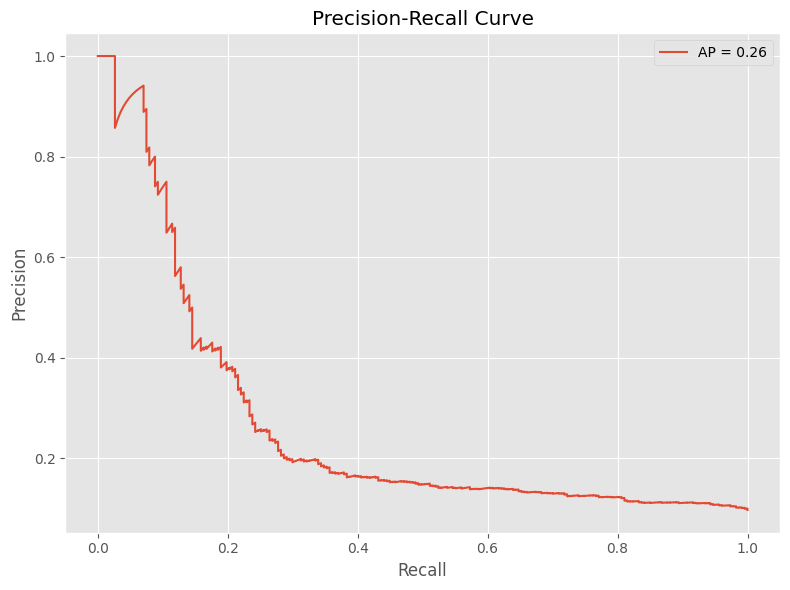

In [49]:
plot_precision_recall_curve(y_val, y_pred_proba)

### Feature Importance

In [50]:
split_importance = model_lgbm_no_sampling.feature_importances_
gain_importance  = model_lgbm_no_sampling.booster_.feature_importance(importance_type = 'gain')

feature_importance = pd.DataFrame({
    "feature": x_train.columns,
    "split_importance": split_importance,
    "gain_importance": gain_importance
}).sort_values("gain_importance", ascending=False)

print(feature_importance.head(10))


                      feature  split_importance  gain_importance
6     forecast_meter_rent_12m               233      7766.833313
11       margin_gross_pow_ele               219      6753.030962
0                    cons_12m               177      5891.441156
14                 net_margin               180      5014.347089
3           forecast_cons_12m               129      4395.010139
19    days_since_modification               153      4308.010819
18             days_until_end               143      4307.752750
17            contract_length               113      4228.930335
49     std_price_off_peak_var               110      3721.926609
29  energy_peak_minus_offpeak               101      3707.633657


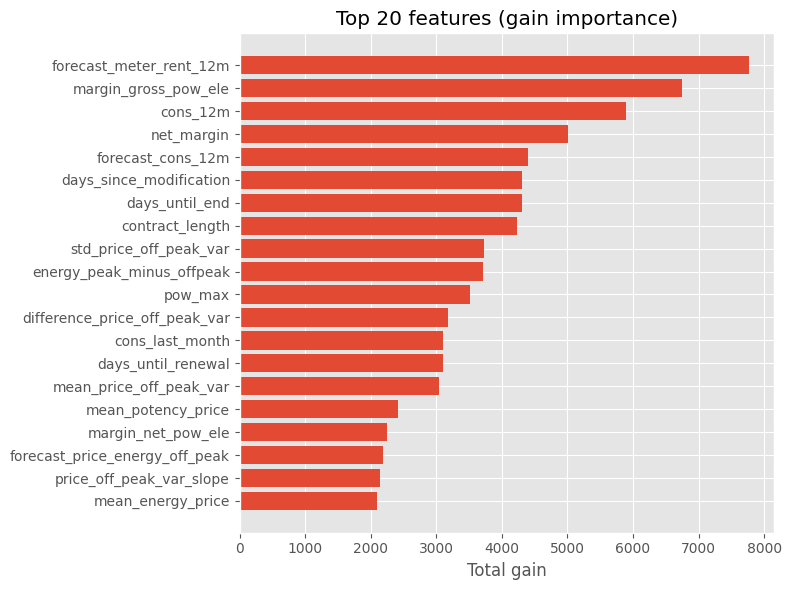

In [51]:
top_k = 20
feature_importance_top = feature_importance.head(top_k).iloc[::-1]        # reverse for horizontal bar

plt.figure(figsize=(8, 6))
plt.barh(feature_importance_top["feature"], feature_importance_top["gain_importance"])
plt.title(f"Top {top_k} features (gain importance)")
plt.xlabel("Total gain")
plt.tight_layout()
plt.show()

## Logistic Regression

In [52]:
clf = LogisticRegression(random_state = random_seed,
                        max_iter = 1000, 
                        class_weight = 'balanced')
clf.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [53]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_no_sampling')




Accuracy:  0.6119
Precision: 0.1436
Recall:    0.6035
F1 Score:  0.2320
ROC AUC:   0.6569

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.60      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.61      0.49      2337
weighted avg       0.86      0.61      0.69      2337



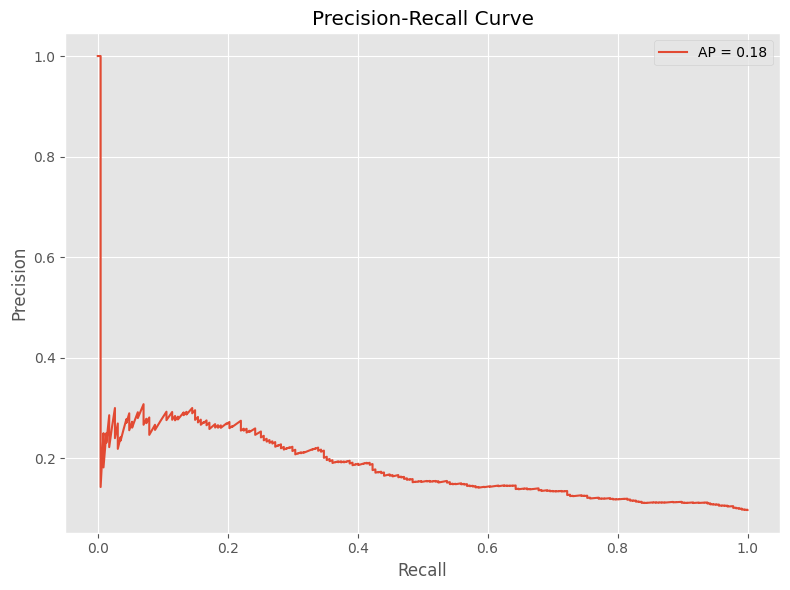

In [54]:
plot_precision_recall_curve(y_val, y_pred_proba)

## Sampling

### Random under-sampling

#### LightGBM

In [55]:
rus = RandomUnderSampler(random_state = random_seed)
x_train_rus_resampled, y_train_rus_resampled = rus.fit_resample(x_train, y_train)

In [56]:
model_lgbm = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)
model_lgbm.fit(x_train_rus_resampled, y_train_rus_resampled)


[LightGBM] [Info] Number of positive: 908, number of negative: 908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7406
[LightGBM] [Info] Number of data points in the train set: 1816, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [57]:
y_pred = model_lgbm.predict(x_val)
y_pred_proba = model_lgbm.predict_proba(x_val)[:, 1]  # For AUC

lgbm_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_rus')


Accuracy:  0.6119
Precision: 0.1344
Recall:    0.5507
F1 Score:  0.2161
ROC AUC:   0.6395

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.74      2110
           1       0.13      0.55      0.22       227

    accuracy                           0.61      2337
   macro avg       0.53      0.58      0.48      2337
weighted avg       0.85      0.61      0.69      2337



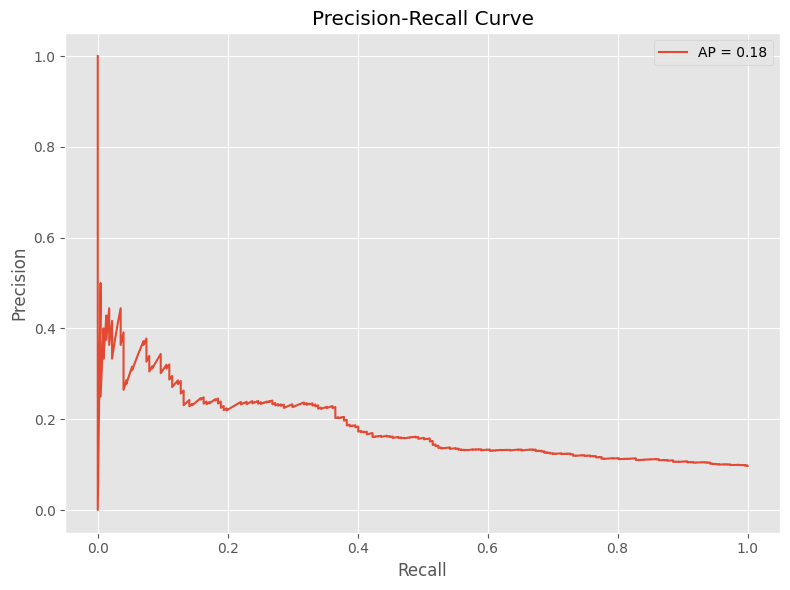

In [58]:
plot_precision_recall_curve(y_val, y_pred_proba)

#### Logistic Regression

In [59]:
clf.fit(x_train_rus_resampled, y_train_rus_resampled)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [60]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')


Accuracy:  0.6089
Precision: 0.1411
Recall:    0.5947
F1 Score:  0.2280
ROC AUC:   0.6474

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



### Smote

In [61]:
x_train_smote, y_train_smote = SMOTE(random_state = random_seed).fit_resample(x_train, y_train)


##### LightGBM

In [62]:
model_lgbm.fit(x_train_smote, y_train_smote)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 8439, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13027
[LightGBM] [Info] Number of data points in the train set: 16878, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [63]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

lgbm_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_smote')


Accuracy:  0.6089
Precision: 0.1411
Recall:    0.5947
F1 Score:  0.2280
ROC AUC:   0.6474

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



#### Logistic Regression

In [64]:
clf.fit(x_train_smote, y_train_smote)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [65]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')

Accuracy:  0.6170
Precision: 0.1424
Recall:    0.5859
F1 Score:  0.2291
ROC AUC:   0.6534

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.62      2337
   macro avg       0.54      0.60      0.49      2337
weighted avg       0.86      0.62      0.70      2337



## Feature Selection

Model-based feature importance

In [66]:
selector = SelectFromModel(model_lgbm_no_sampling, threshold="median", prefit=True)
x_train_selected = selector.transform(x_train)
x_val_selected = selector.transform(x_val)
x_test_selected = selector.transform(x_test)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [67]:
model_selected_no_sampling = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)

model_selected_no_sampling.fit(x_train_selected, y_train)

[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7854
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [68]:
y_pred = model_selected_no_sampling.predict(x_val_selected)
y_pred_proba = model_selected_no_sampling.predict_proba(x_val_selected)[:, 1]  # For AUC
lgbm_no_sampling_selected = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_ns_selected')

Accuracy:  0.8194
Precision: 0.2206
Recall:    0.3392
F1 Score:  0.2674
ROC AUC:   0.6734

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      2110
           1       0.22      0.34      0.27       227

    accuracy                           0.82      2337
   macro avg       0.57      0.61      0.58      2337
weighted avg       0.86      0.82      0.84      2337



## Results - Comparisson

In [69]:
results = pd.concat([lgbm_no_sampling, lgbm_rus, lgbm_smote, lgbm_no_sampling_selected, 
                logistic_no_sampling, logistic_rus, logistic_smote], axis = 1)

Two models were tested: LightGBM and Logistic Regression.
They were trained on four variations of the dataset:

    1. Full dataset with all features;
    2. Randomly undersampled dataset;
    3. SMOTE-oversampled dataset;
    4. Dataset with all samples but a reduced number of features.


- lgbm_no_sampling:
    - model: lightgbm.
    - dataset: no sampling, all features.

- lgbm_rus:
    - model: lightgbm.
    - dataset: random undersampled, all features.

- lgbm_smote:
    - model: lightgbm.
    - dataset: oversampled (SMOTE), all features.

- lgbm_no_sampling_selected:
    - model: lightgbm.
    - dataset: no sampling, only selected features.

- logistic_no_sampling:
    - model: logistic regression.
    - dataset: no sampling, all features.

- logistic_rus:
    - model: logistic regression.
    - dataset: random undersampled, all features.

- logistic_smote:
    - model: logistic regression.
    - dataset: oversampled (SMOTE), all features.



In [70]:
results

,lgbm_no_sampling,lgbm_rus,lightgbm_smote,lightgbm_ns_selected,logistic_no_sampling,logistic_rus,logistic_rus
accuracy,0.544288,0.611896,0.608900,0.819427,0.611896,0.608900,0.617030
precision,0.132456,0.134409,0.141066,0.220630,0.143606,0.141066,0.142398
recall,0.665198,0.550661,0.594714,0.339207,0.603524,0.594714,0.585903
f1,0.220922,0.216076,0.228041,0.267361,0.232007,0.228041,0.229113
roc_auc,0.653740,0.639476,0.647381,0.673369,0.656928,0.647381,0.653429


## Discount Effect

The effect of price reductions on the probability of customer churn will be tested. However, there are other features in the dataset that are affected by prices: margin_gross_pow_ele, margin_net_pow_ele, and net_margin. No information was provided on how these three features vary when prices change. Therefore, three alternatives will be tested:

1. Train the model using the full dataset and then test it on an altered version of the test dataset.
This altered version consists of a discount applied to the price features (new_price = 0.85 × price), while the three price-dependent features are left unchanged.

2. Train the model using the full dataset and then test it on an altered version of the test dataset.
This altered version applies the same price discount (new_price = 0.85 × price) but assumes a simplified relationship between prices and the three other features.

3. Create a new dataset by removing the three price-dependent features from the original dataset.
Train the model on this reduced dataset, then test it on an altered version of the same dataset with the discounted prices (new_price = 0.85 × price).

In [71]:
x_val = x_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [72]:
y_pred_proba_no_discount = model_lgbm_no_sampling.predict_proba(x_val)
y_pred_proba_no_discount = pd.DataFrame(y_pred_proba_no_discount, columns = ['prob_not_churned', 'prob_churned'])
y_pred_proba_no_discount = pd.concat([y_pred_proba_no_discount, y_val], axis = 1)
y_pred_proba_no_discount


,prob_not_churned,prob_churned,churn
0,0.390424,0.609576,0
1,0.793773,0.206227,1
2,0.599205,0.400795,0
3,0.098485,0.901515,0
4,0.941350,0.058650,0
...,...,...,...
2332,0.815263,0.184737,0
2333,0.818704,0.181296,0
2334,0.895526,0.104474,0
2335,0.662414,0.337586,0


In [80]:
churned_no_discount = y_pred_proba_no_discount[y_pred_proba_no_discount['churn'] == 1]

n_churned = len(churned_no_discount)
n_correct_preds = len(churned_no_discount[churned_no_discount['prob_churned'] > 0.5])

print('Number of clients that churned:', n_churned)
print('Number of correct predictions (no discount):', n_correct_preds)
print(f'Proportion: {100*n_correct_preds/n_churned:.2f}%')



Number of clients that churned: 227
Number of correct predictions (no discount): 151
Proportion: 66.52%


Text(0.5, 0, 'Sample')

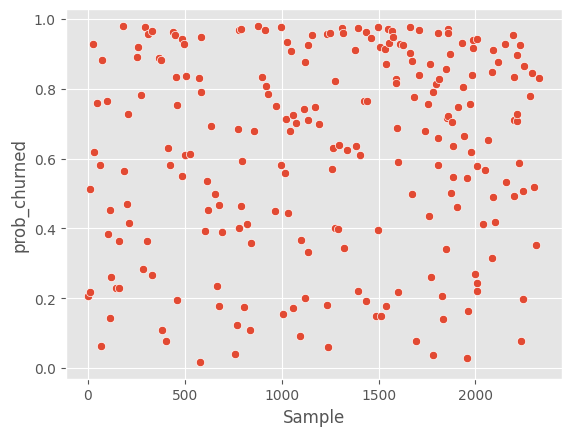

In [81]:
sns.scatterplot(x = churned_no_discount.index, y = churned_no_discount['prob_churned'])
plt.xlabel('Sample')


In [82]:
y_pred_proba_discount = model_lgbm_no_sampling.predict_proba(x_val_discount)
y_pred_proba_discount = pd.DataFrame(y_pred_proba_discount, columns = ['prob_not_churned_discount', 'prob_churned_discount'])
y_pred_proba_discount = pd.concat([y_pred_proba_discount, y_val], axis = 1)
y_pred_proba_discount

,prob_not_churned_discount,prob_churned_discount,churn
0,0.433757,0.566243,0
1,0.907122,0.092878,1
2,0.901328,0.098672,0
3,0.436046,0.563954,0
4,0.974487,0.025513,0
...,...,...,...
2332,0.814631,0.185369,0
2333,0.838271,0.161729,0
2334,0.831558,0.168442,0
2335,0.434920,0.565080,0


In [83]:
churned_discount = y_pred_proba_discount[y_pred_proba_discount['churn'] == 1]
n_pred_chrurned_discount = len(churned_discount[churned_discount['prob_churned_discount'] > 0.5])

print('Number of churned predictions after applying discount:', n_pred_chrurned_discount)

Number of churned predictions after applying discount: 98


Text(0.5, 0, 'Sample')

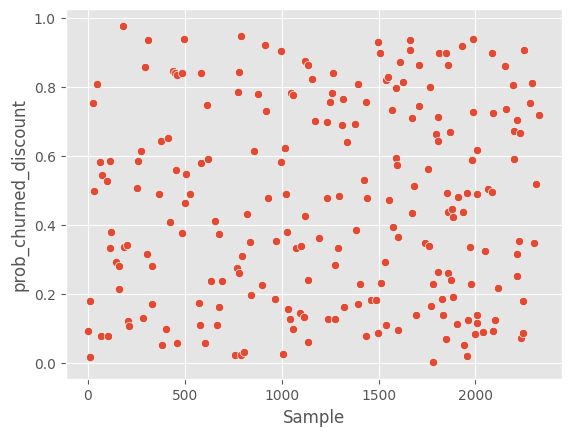

In [78]:
sns.scatterplot(x = churned_discount.index, y = churned_discount['prob_churned_discount'])
plt.xlabel('Sample')

Text(0, 0.5, 'Predicted probability')

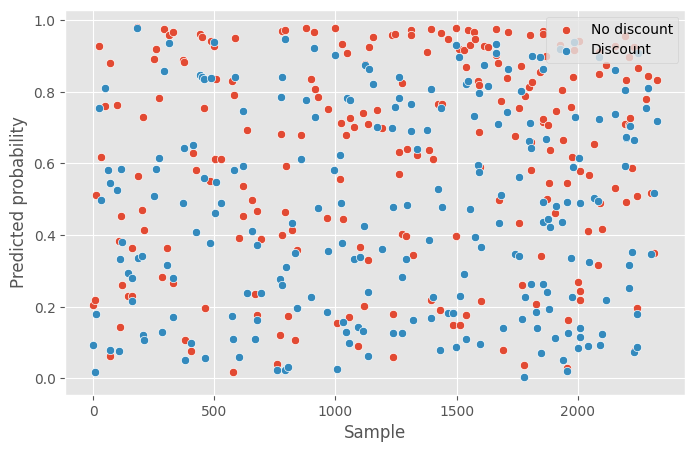

In [79]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x = churned_no_discount.index, y = churned_no_discount['prob_churned'], label = 'No discount')
sns.scatterplot(x = churned_discount.index, y = churned_discount['prob_churned_discount'], label = 'Discount')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Predicted probability')


In [80]:
comparison = pd.concat([churned_no_discount, churned_discount], axis = 1)
comparison = comparison.loc[comparison['prob_churned'] > 0.5, ['prob_churned', 'prob_churned_discount']]

In [ ]:
# This predicitions are only for clients that churned
comparison

,prob_churned,prob_churned_discount
13,0.512064,0.180544
25,0.927802,0.754010
31,0.619112,0.498874
49,0.760069,0.809354
61,0.582868,0.582849
...,...,...
2251,0.866346,0.907385
2283,0.780446,0.754220
2290,0.844172,0.812028
2302,0.517469,0.348289


Text(0, 0.5, 'Predicted probability')

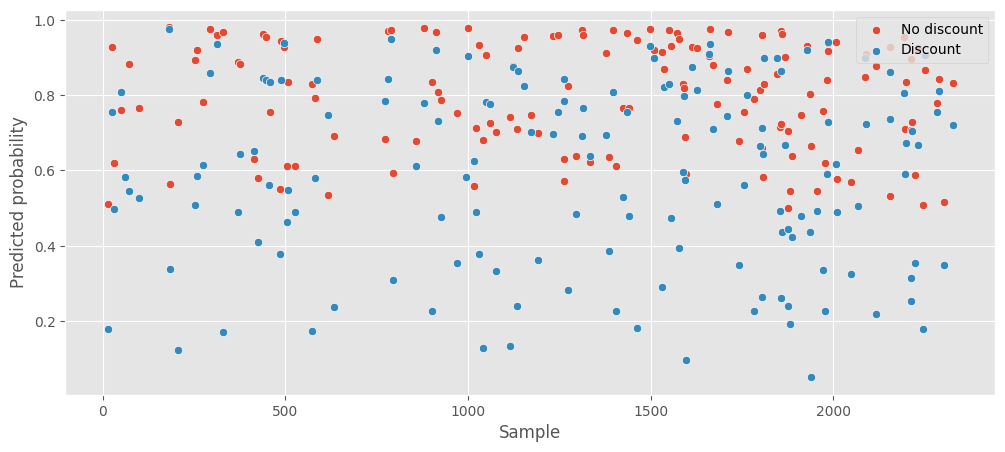

In [82]:
plt.figure(figsize=(12, 5))

sns.scatterplot(x = comparison.index, y = comparison['prob_churned'], label = 'No discount')
sns.scatterplot(x = comparison.index, y = comparison['prob_churned_discount'], label = 'Discount')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Predicted probability')

## Shap

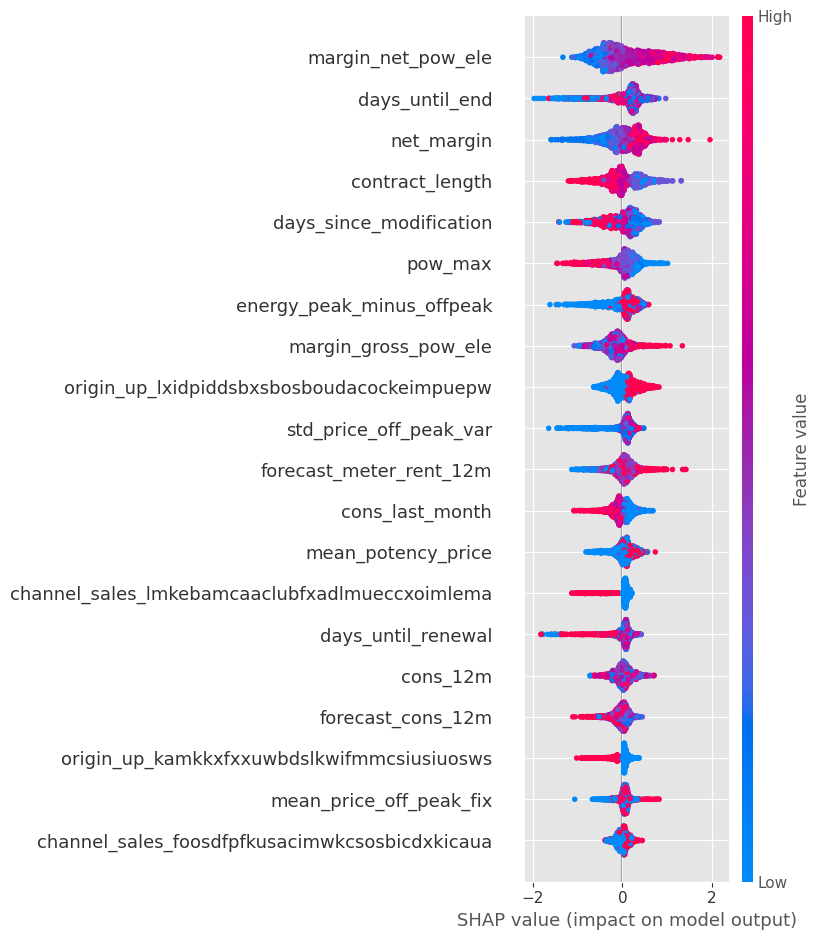

In [70]:
explainer = shap.TreeExplainer(model_lgbm_no_sampling)
shap_values_no_discount = explainer(x_val)
shap.summary_plot(shap_values_no_discount, x_val)


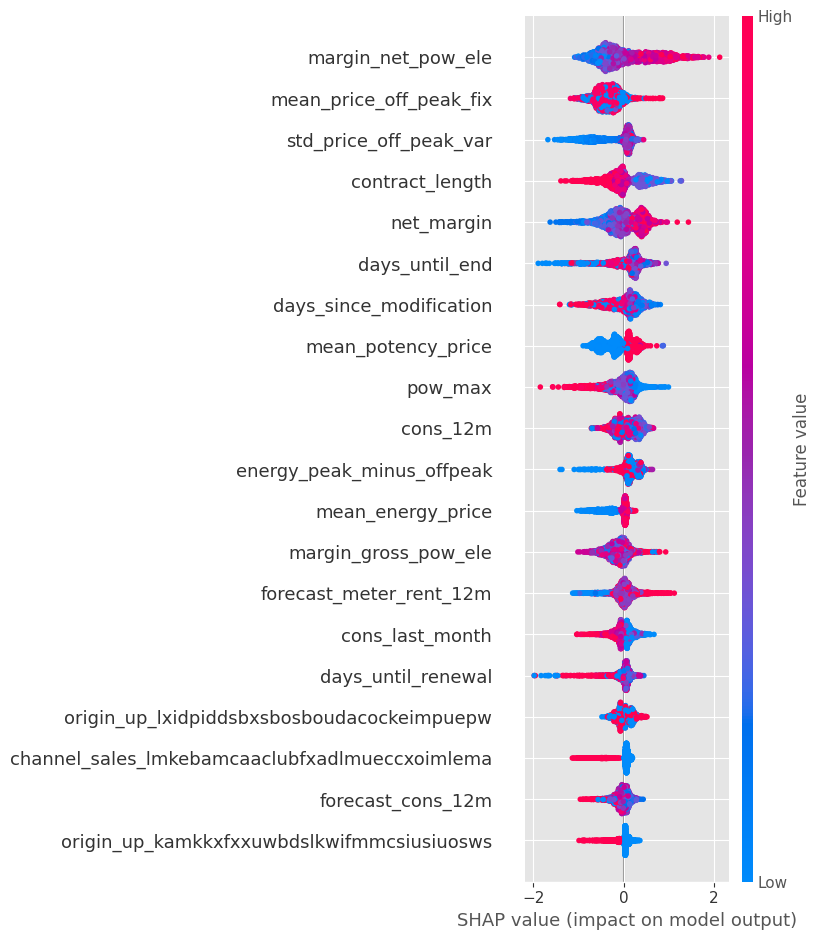

In [71]:
shap_values_discount = explainer(x_val_discount)
shap.summary_plot(shap_values_discount, x_val_discount)

### Individual Predictions

In [72]:
y_pred_proba_no_discount.sort_values(by = 'prob_churned', ascending = False)

,prob_not_churned,prob_churned,churn
181,0.019714,0.980286,1
880,0.020736,0.979264,1
999,0.021903,0.978097,1
1499,0.023235,0.976765,1
1663,0.023874,0.976126,1
...,...,...,...
721,0.998435,0.001565,0
32,0.998524,0.001476,0
419,0.999465,0.000535,0
1368,0.999638,0.000362,0


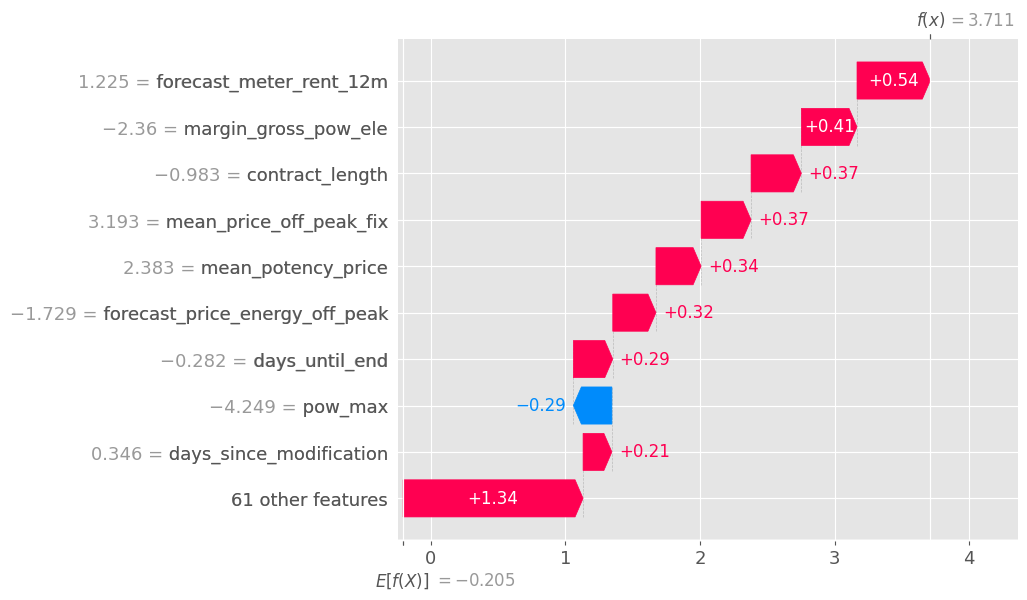

In [73]:
explainer_no_discount = shap.Explainer(model_lgbm_no_sampling, x_val)
shap_values = explainer(x_val)
shap.plots.waterfall(shap_values[1663])

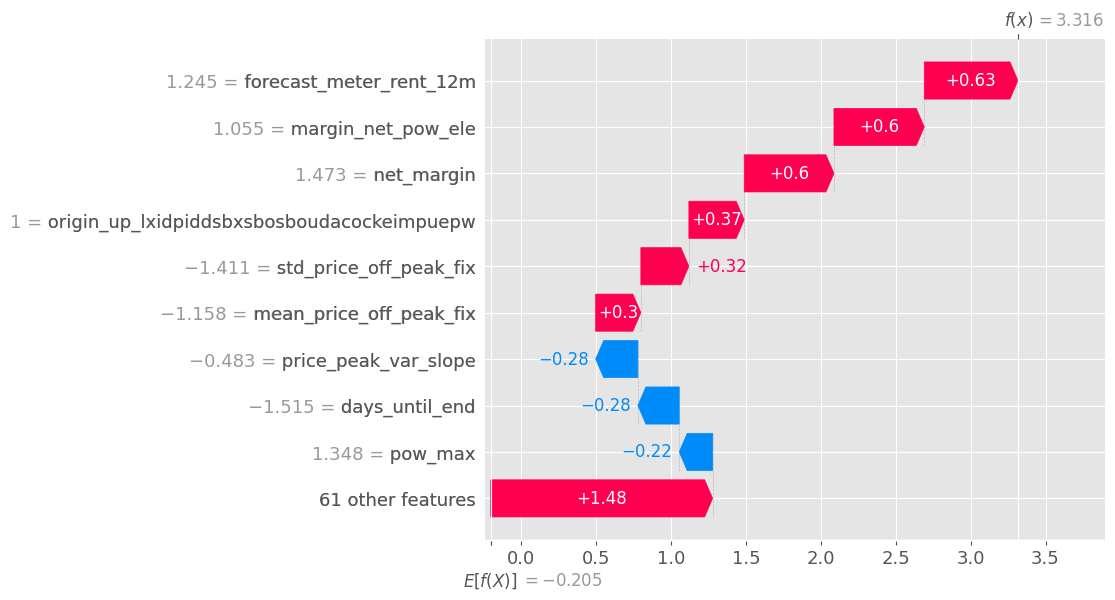

In [74]:
shap.plots.waterfall(shap_values[430])

# Mlflow

In [75]:
mlflow.set_tracking_uri("file:../mlruns")  # Goes one level up
mlflow.set_experiment("powerco_churn")

with mlflow.start_run(run_name="ML_notebook"):
    mlflow.log_artifact("ML.ipynb")